In [13]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filepath = os.path.abspath('')
utilpath = f'{filepath}/../util/'
sys.path.append(utilpath)

from melbourne import Melbourne

melb_data = pd.read_hdf(f'{filepath}/../data/melb_data.h5')

params = [
    {
        'alpha': alpha,
    }
    for alpha in np.arange(0, 1e-3, 1e-4)[1:]
]
param_names = list(params[0].keys())

In [14]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

linear_feature_candidates = [
    'Rooms', 
    'Bedroom2',
    'Bathroom',
    'Car',
    'Landsize',
    'BuildingArea',
    'Price',
]

melbourne = Melbourne(melb_data.loc[:, linear_feature_candidates], frac=1)

# metric = mean_absolute_error
metric = mean_squared_error
melbourne.over_under_fit(algorithm=linear_model.HuberRegressor, metric=metric, params=params)

data = dict([
    (param_name, [ param[param_name] for param in params])
    for param_name in param_names
])
data[metric.__name__] = melbourne.errors

param_df = pd.DataFrame.from_dict(data)

param_argmin = param_df[metric.__name__].argmin()
param_argmax = param_df[metric.__name__].argmax()
# param_argmin = df.iloc[ [ df[metric.__name__].argmin() ] ]
# WARNING:  Don't pass the argmin as an integer instead of a list containing 
#           that integer, i. e. don't do
#
#               param_argmin = df.iloc[ df[metric.__name__].argmin() ]
#
#           because then `param_argmin` will be a `pandas.Series` and not a
#           `pandas.DataFrame` in which case the dtype information seems to
#           have to be consistent across all entries. This however breaks the 
#           usage of **param_opt as **kwargs in model initialization.

param_opt = dict([
    (param_name, param_df.loc[param_argmin, param_name])
    for param_name in param_names
])

print(f'''
Optimal parameter configuration with minimum {metric.__name__}:

param_opt     =     {'    '.join([ str(f'{p}: {v}') for p, v in param_opt.items()])}
''')

param_df

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati


Optimal parameter configuration with minimum mean_squared_error:

param_opt     =     alpha: 0.0001



,alpha,mean_squared_error
0,0.0001,2.772753e+11
1,0.0002,2.784357e+11
2,0.0003,2.783164e+11
3,0.0004,2.782232e+11
4,0.0005,2.779363e+11
5,0.0006,2.780391e+11
6,0.0007,2.774638e+11
7,0.0008,2.779395e+11
8,0.0009,2.779991e+11


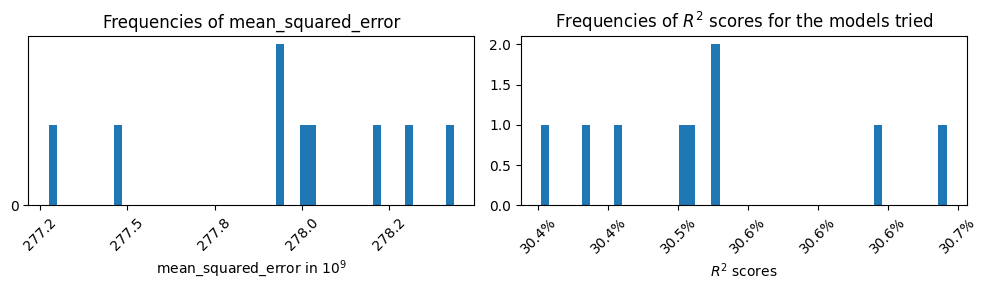

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator
from matplotlib.ticker import ScalarFormatter, FuncFormatter, PercentFormatter

max_mean_absolute_error = param_df[metric.__name__].max(axis=0)
min_mean_absolute_error = param_df[metric.__name__].min(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10,3))

ax = axes[0]

ax.hist(melbourne.errors, bins=50)

exponent = np.floor(np.log10(max_mean_absolute_error - min_mean_absolute_error))
base10 = 10 ** exponent

ax.set_title(f'Frequencies of {metric.__name__}')
ax.xaxis.set_major_locator(MultipleLocator(base=base10 / 4))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / base10 :,.1f}'))
ax.set_xlabel(f'{metric.__name__} in $10^{{{exponent:.0f}}}$')
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.tick_params(axis='x', rotation=45)

ax = axes[1]

r2_argbest, r2_argworst = np.argmax(melbourne.r2_scores), np.argmin(melbourne.r2_scores)
r2_best, r2_worst = melbourne.r2_scores[r2_argbest], melbourne.r2_scores[r2_argworst]
assert param_argmin == r2_argbest and param_argmax == r2_argworst

ax.set_title(f'Frequencies of $R^2$ scores for the models tried')
ax.hist(melbourne.r2_scores, bins=50)

ax.xaxis.set_major_locator(MultipleLocator(base=.0005))
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=1))
ax.set_xlabel(f'$R^2$ scores')
ax.tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

If the $R^2$ scores are within a similar percentage range, we can infer that the parameters are not a decisive game changer for a prediction.
We must therefore change the model.

In [17]:
# Explore the DecisionTreeRegressor with parameters performing best on the test 
# set in more detail.

# Train the best model on all data, not just the training data:

best_melbourne_model = linear_model.HuberRegressor(**param_opt)

best_melbourne_model.fit(melbourne.X, melbourne.y)

# ... and predict

best_melbourne_model.fit(melbourne.train_X, melbourne.train_y)

predict_y = best_melbourne_model.predict(melbourne.test_X)

if metric.__name__ == 'mean_squared_error':
    prediction_to_actual_ratio = metric(melbourne.test_y, predict_y) ** .5 / melbourne.mean_price
elif metric.__name__ == 'mean_absolute_error':
    prediction_to_actual_ratio = metric(melbourne.test_y, predict_y) / melbourne.mean_price

print(f'''
prediction-to-actual ratios:
      
{prediction_to_actual_ratio}

mean of prediction-to-actual ratios:

{predict_y.mean(axis=0) / melbourne.mean_price}
''')


prediction-to-actual ratios:
      
0.48952043552103064

mean of prediction-to-actual ratios:

0.9166285785688018



/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
